# Data augmentation

Notebook contains training and validation of XGBoost models in three prediction cases - multiclass classification (stages: I, II, III, IV), and two binary classifications (stages: I-III vs IV and I-II vs III-IV), after training data augmentation (and previous dimensionaity reduction). Different SMOTE-based methods are tried, as well as simple augmentation via adding random noise to existing samples.

In [1]:
import os
import pickle
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/all_features/data_augmentation/multiclass/'
output_dir_binary = '../results/updated_data/all_features/data_augmentation/binary/'
output_dir_binary_2 = '../results/updated_data/all_features/data_augmentation/binary_I-II_vs_III-IV/'

Load training data (after dimensionality reduction)

In [4]:
data_path = '../data/cleaned/updated/all_features/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 5331 entries, ID to CASC15
dtypes: float64(5327), object(4)
memory usage: 35.4+ MB


Define functions for cross validation (they get additional argument which is an over-sampler object)

In [5]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        over_sampler,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])
        
        y_train = y.iloc[train_index]
        X_train = X.iloc[train_index]
        
        y_test = y.iloc[test_index]
        X_test = X.iloc[test_index]
        
        X_train_augmented, y_train_augmented = over_sampler.fit_resample(X_train, y_train)
        estimator.fit(X=X_train_augmented, y=y_train_augmented, verbose=False)

        y_pred = estimator.predict(X_test)
        scores[i] = scoring(list(y_test), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        over_sampler,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])
        
        y_train = y.iloc[train_index]
        X_train = X.iloc[train_index]
        
        y_test = y.iloc[test_index]
        X_test = X.iloc[test_index]
        
        X_train_augmented, y_train_augmented = over_sampler.fit_resample(X_train, y_train)
        estimator.fit(X=X_train_augmented, y=y_train_augmented, verbose=False)
        
        y_pred[test_index] = estimator.predict(X_test)

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [6]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring, over_sampler):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        over_sampler=over_sampler,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### Data preparation

In these experiments, a reduced subset of columns is used based on the results from dimensionality_reduction notebook. For each prediction case, we take the features subset for which the best score was obtained.

Multiclass classification

In [8]:
X_train_multiclass = train.copy(deep=True)

labels_encoding_multiclass = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
y_train_multiclass = X_train_multiclass['Stage'].map(labels_encoding_multiclass)

stratification_groups_multiclass = X_train_multiclass.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train_multiclass = X_train_multiclass.drop(columns=['ID', 'Sex', 'Age', 'Group', 'Stage'])

best_features_folder_path = '../results/updated_data/all_features/dimensionality_reduction/multiclass/'
best_features_filename = 'feature_importances_backward_elimination_3_iteration_used_features.obj'
with open (os.path.join(best_features_folder_path, best_features_filename), 'rb') as file:
    best_features = pickle.load(file)
    
X_train_reduced_multiclass = X_train_multiclass.loc[:, best_features]
X_train_reduced_multiclass['Stage'] = y_train_multiclass.values

X_train_reduced_multiclass.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 172 entries, RECQL to Stage
dtypes: float64(171), int64(1)
memory usage: 1.1 MB


Binary classification

In [9]:
X_train_binary = train.copy(deep=True)

mapping_binary = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train_binary.loc[:, 'Stage'] = X_train_binary['Stage'].map(mapping_binary)
stratification_groups_binary = X_train_binary.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)

labels_encoding_binary = {
    'I-III': 0,
    'IV': 1
}
y_train_binary = X_train_binary['Stage'].map(labels_encoding_binary)
X_train_binary = X_train_binary.drop(columns=['ID', 'Sex', 'Age', 'Group', 'Stage'])

best_features_folder_path = '../results/updated_data/all_features/dimensionality_reduction/binary/'
best_features_filename = 'feature_importances_backward_elimination_3_iteration_used_features.obj'
with open (os.path.join(best_features_folder_path, best_features_filename), 'rb') as file:
    best_features = pickle.load(file)

X_train_reduced_binary = X_train_binary.loc[:, best_features]
X_train_reduced_binary['Stage'] = y_train_binary.values

X_train_reduced_binary.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 110 entries, FUCA2 to Stage
dtypes: float64(109), int64(1)
memory usage: 747.8 KB


Binary classification (stages: I-II vs III-IV)

In [10]:
X_train_binary_2 = train.copy(deep=True)

mapping_binary_2 = {
    'I': 'I-II',
    'II': 'I-II',
    'III': 'III-IV',
    'IV': 'III-IV'
}
X_train_binary_2.loc[:, 'Stage'] = X_train_binary_2['Stage'].map(mapping_binary_2)
stratification_groups_binary_2 = X_train_binary_2.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)

labels_encoding_binary_2 = {
    'I-II': 0,
    'III-IV': 1
}
y_train_binary_2 = X_train_binary_2['Stage'].map(labels_encoding_binary_2)
X_train_binary_2 = X_train_binary_2.drop(columns=['ID', 'Sex', 'Age', 'Group', 'Stage'])

best_features_folder_path = '../results/updated_data/all_features/dimensionality_reduction/binary_I-II_vs_III-IV/'
best_features_filename = 'feature_importances_backward_elimination_2_iteration_used_features.obj'
with open (os.path.join(best_features_folder_path, best_features_filename), 'rb') as file:
    best_features = pickle.load(file)

X_train_reduced_binary_2 = X_train_binary_2.loc[:, best_features]
X_train_reduced_binary_2['Stage'] = y_train_binary_2.values

X_train_reduced_binary_2.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 160 entries, BAD to Stage
dtypes: float64(159), int64(1)
memory usage: 1.1 MB


## SMOTE-based methods

### Multiclass classification

In [11]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

Check models performance after data augmentation using different methods

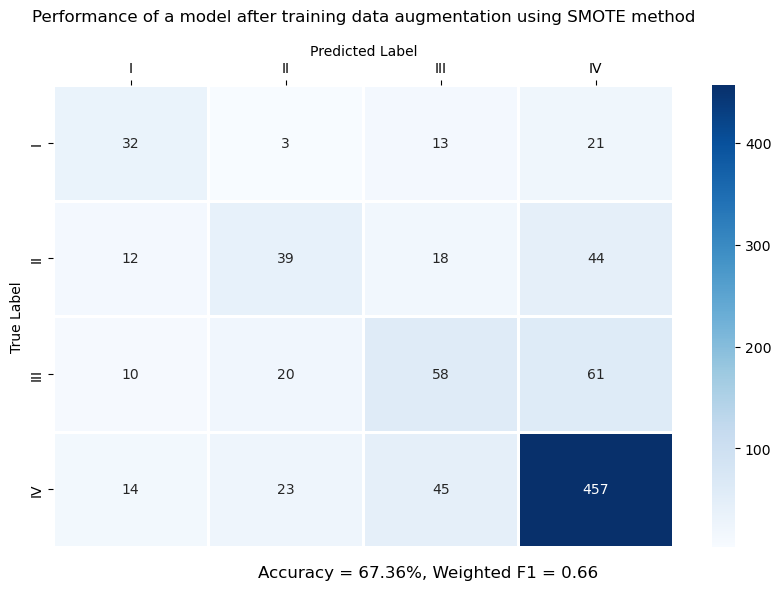

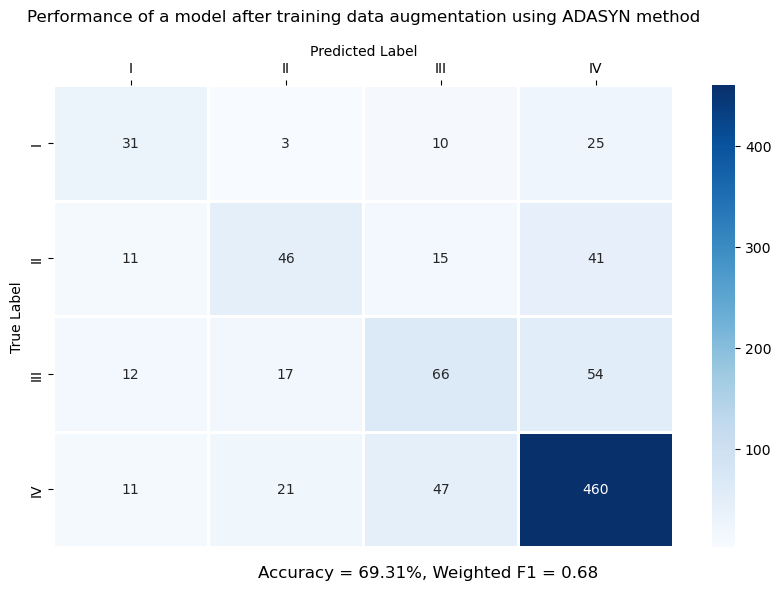

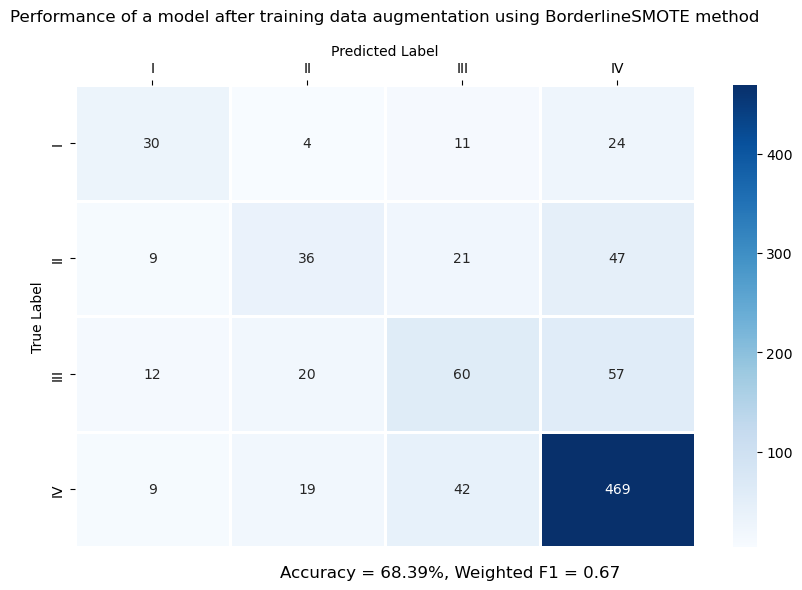

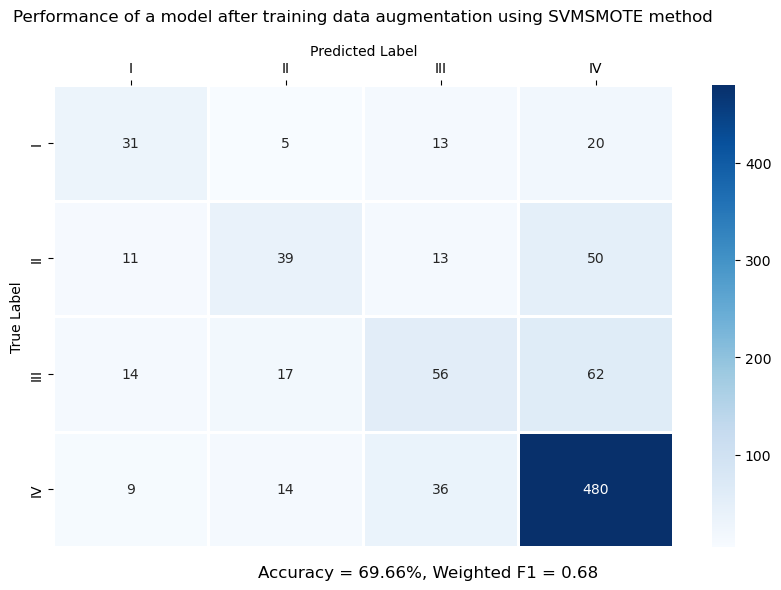

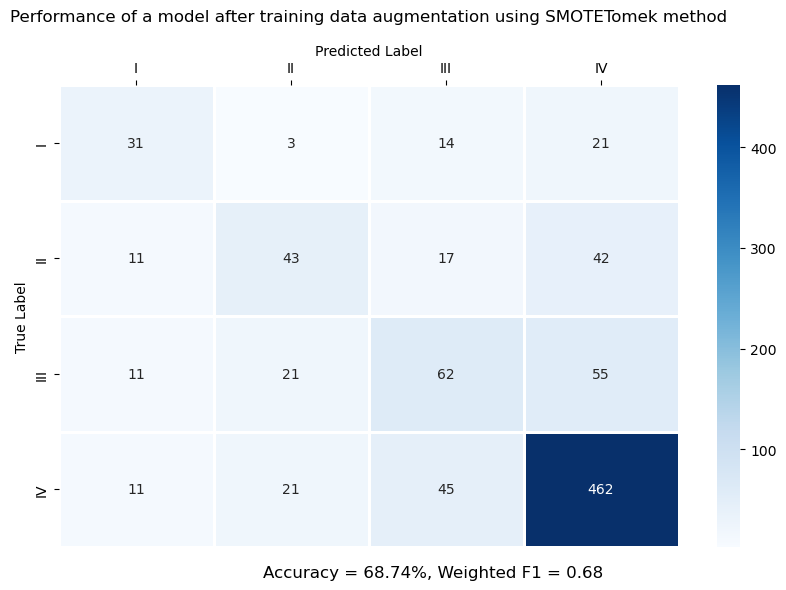

In [12]:
over_samplers = (
    SMOTE(random_state=random_state),
    ADASYN(random_state=random_state),
    BorderlineSMOTE(random_state=random_state),
    SVMSMOTE(random_state=random_state),
    SMOTETomek(random_state=random_state),
)

for over_sampler in over_samplers:
    objective_func = partial(
        objective,
        X_train=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=over_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        over_sampler=over_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_multiclass['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = over_sampler.__class__.__name__
    title = f'Performance of a model after training data augmentation using {over_sampler_name} method'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [13]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

Check models performance after data augmentation using different methods

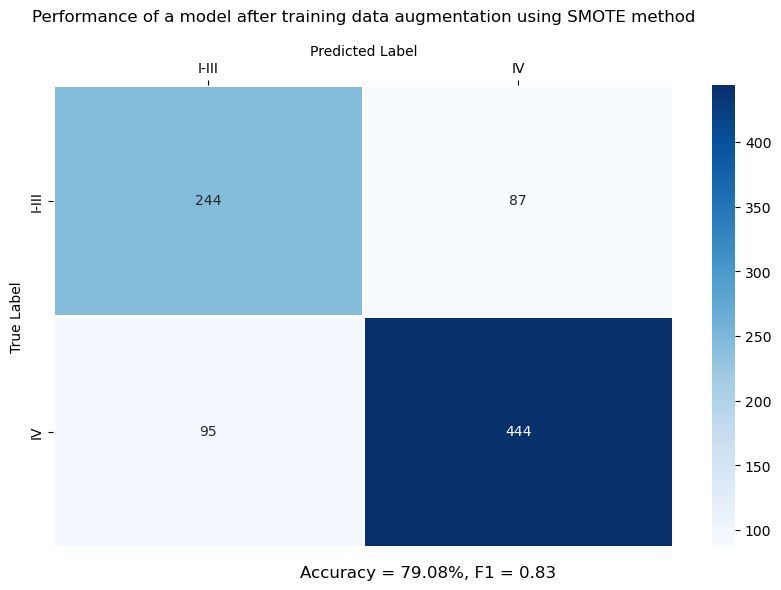

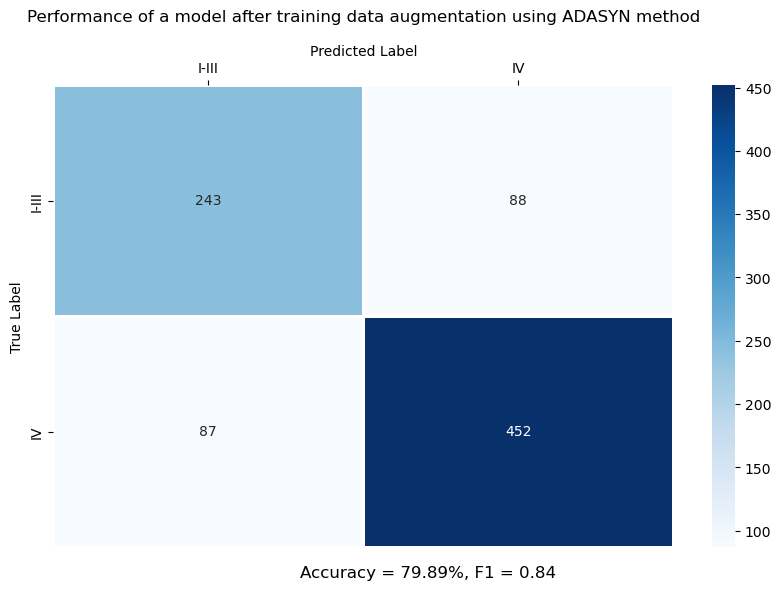

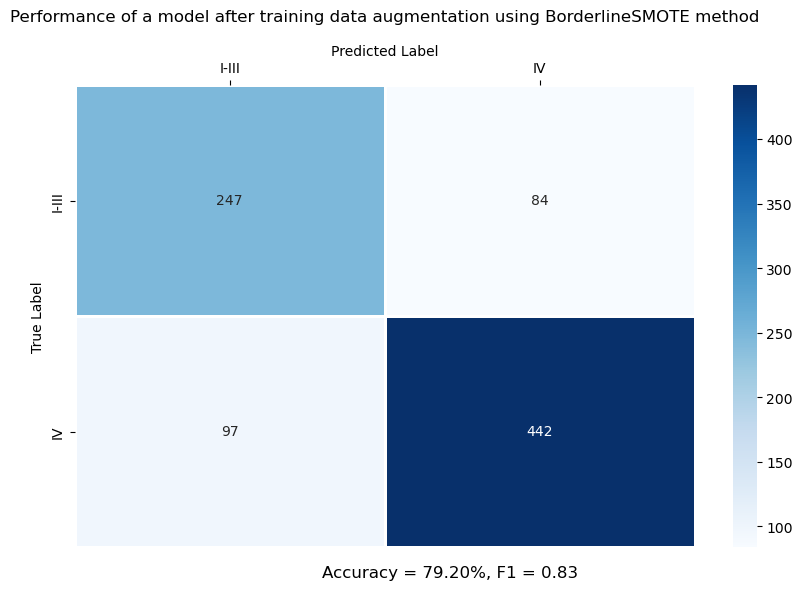

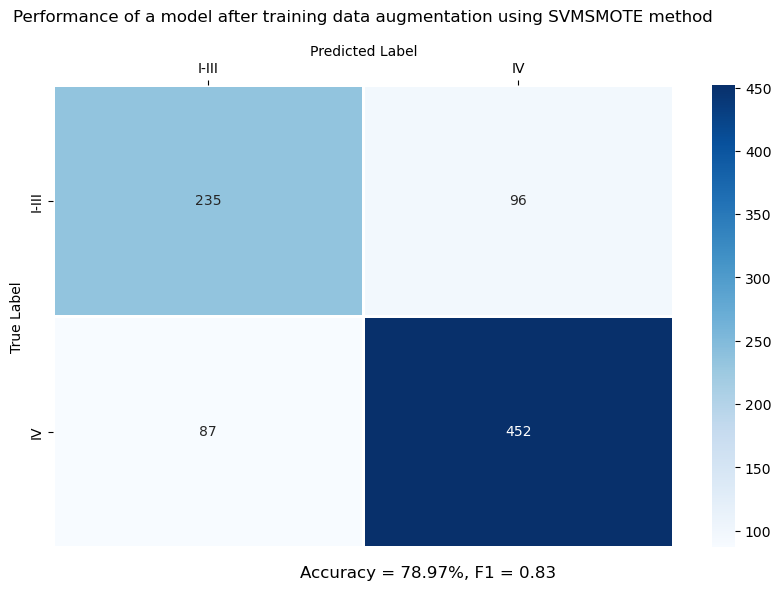

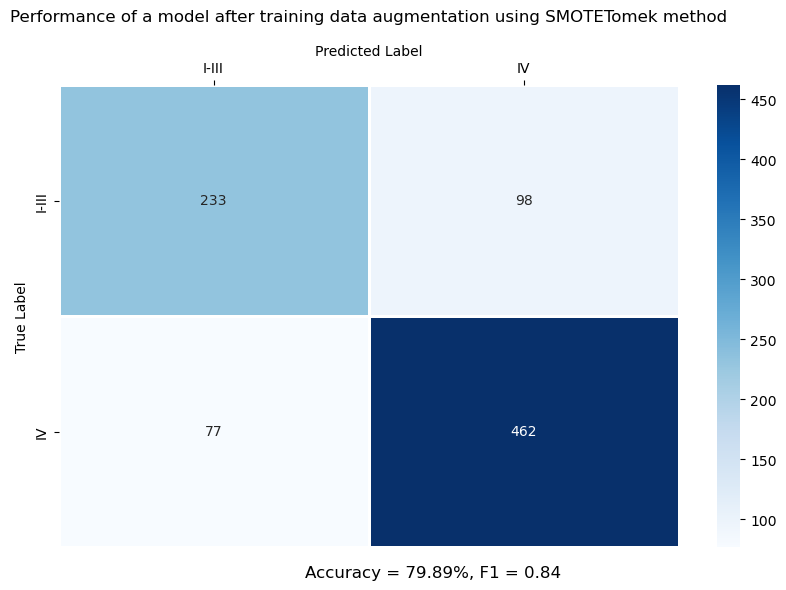

In [14]:
over_samplers = (
    SMOTE(random_state=random_state),
    ADASYN(random_state=random_state),
    BorderlineSMOTE(random_state=random_state),
    SVMSMOTE(random_state=random_state),
    SMOTETomek(random_state=random_state),
)

for over_sampler in over_samplers:
    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=over_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        over_sampler=over_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_binary['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = over_sampler.__class__.__name__
    title = f'Performance of a model after training data augmentation using {over_sampler_name} method'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Binary classification (stages: I-II vs III-IV)

In [15]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

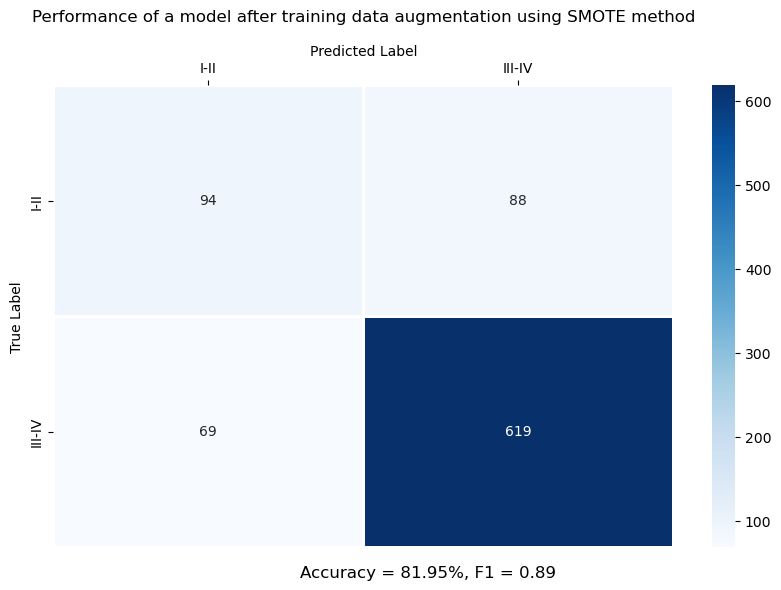

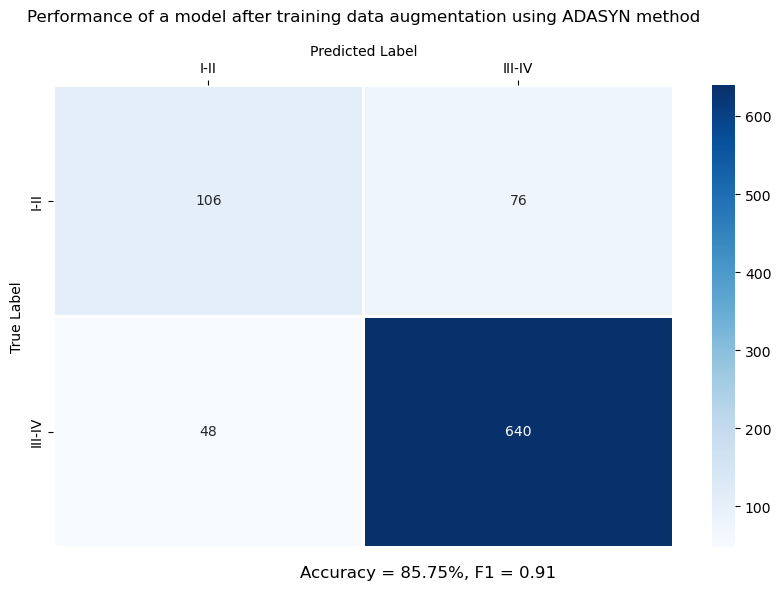

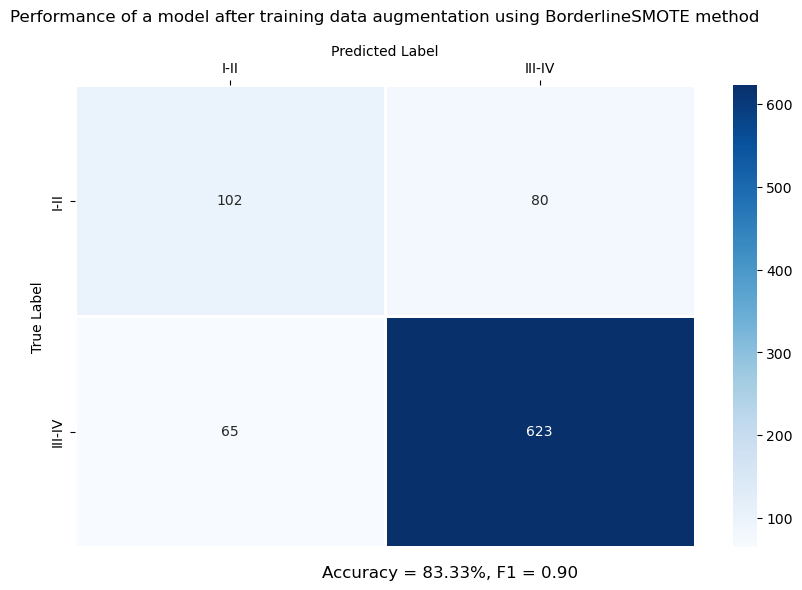

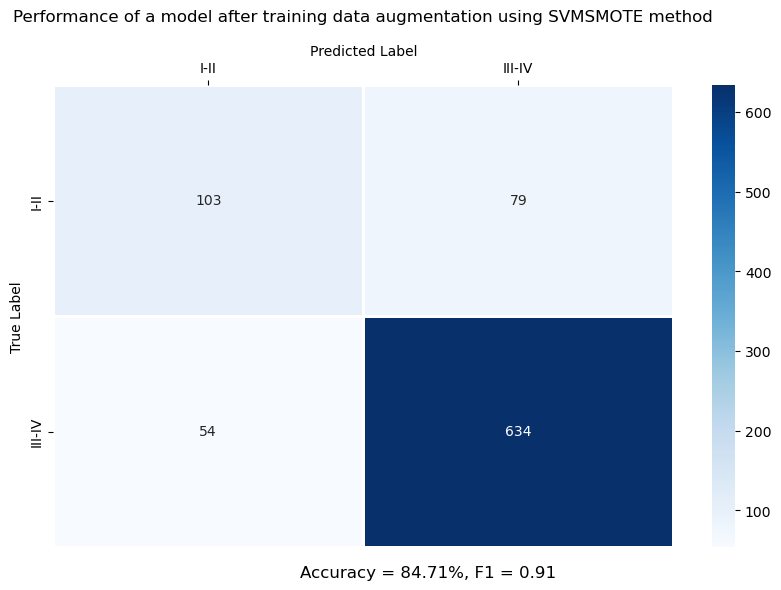

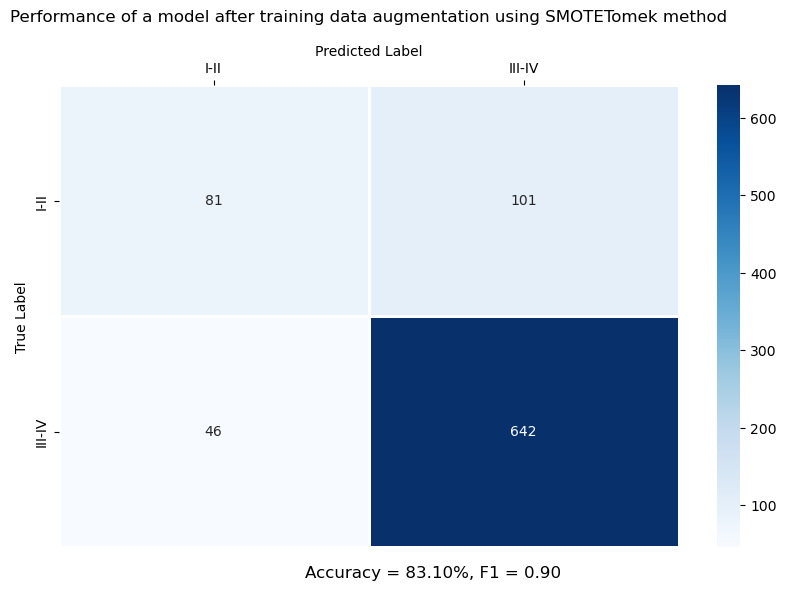

In [16]:
over_samplers = (
    SMOTE(random_state=random_state),
    ADASYN(random_state=random_state),
    BorderlineSMOTE(random_state=random_state),
    SVMSMOTE(random_state=random_state),
    SMOTETomek(random_state=random_state),
)

for over_sampler in over_samplers:
    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=over_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        over_sampler=over_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_binary_2['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = over_sampler.__class__.__name__
    title = f'Performance of a model after training data augmentation using {over_sampler_name} method'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))

## Augmentation with random noise

Define a class for data augmentation with random noise

In [17]:
class NoisyOverSampler:
    
    def __init__(self, n_new_samples, noise_range, equal_noise_value=False, equalize_imbalance=False):
        self.n_new_samples = n_new_samples
        self.noise_range = noise_range
        self.equal_noise_value = equal_noise_value
        self.equalize_imbalance = equalize_imbalance
        
    def _get_n_new_samples_per_class(self, y):
        if not self.equalize_imbalance:
            n_new_samples_per_class = {class_: self.n_new_samples for class_ in y.unique()}
            return n_new_samples_per_class
        
        else:
            class_counts = y.value_counts()
            max_counts = class_counts.max()
            
            n_new_samples_per_class = {class_: (max_counts / counts) * self.n_new_samples + (max_counts - counts) / counts
                                       for class_, counts in class_counts.items()}
                
            return n_new_samples_per_class
    
    def _generate_new_samples(self, x_sample, n_new_samples):
        if self.equal_noise_value:
            x_new_samples = np.array([x_sample + np.full(x_sample.size, np.random.uniform(-self.noise_range, self.noise_range, 1)[0])
                                    for _ in range(n_new_samples)])
            return x_new_samples
        
        else:
            x_new_samples = np.array([x_sample + np.random.uniform(-self.noise_range, self.noise_range, x_sample.size)
                                      for _ in range(n_new_samples)])
            return x_new_samples
            
    
    def fit_resample(self, X, y):
        n_new_samples_per_class = self._get_n_new_samples_per_class(y)
        
        X_resampled = X.values.copy()
        y_resampled = y.values.copy()
        
        for x_sample, y_sample in zip(X.values, y.values):
            n_new_samples = int(n_new_samples_per_class[y_sample])
            
            if np.random.random() < n_new_samples_per_class[y_sample] % 1:
                n_new_samples += 1
            
            y_new_samples = np.full(n_new_samples, fill_value=y_sample)
            x_new_samples = self._generate_new_samples(x_sample, n_new_samples)
            
            y_resampled = np.concatenate((y_resampled, y_new_samples))
            X_resampled = np.concatenate((X_resampled, x_new_samples))
        
        return X_resampled, y_resampled

### Multiclass classification

In [18]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

Check models performance after data augmentation using random noise with different settings

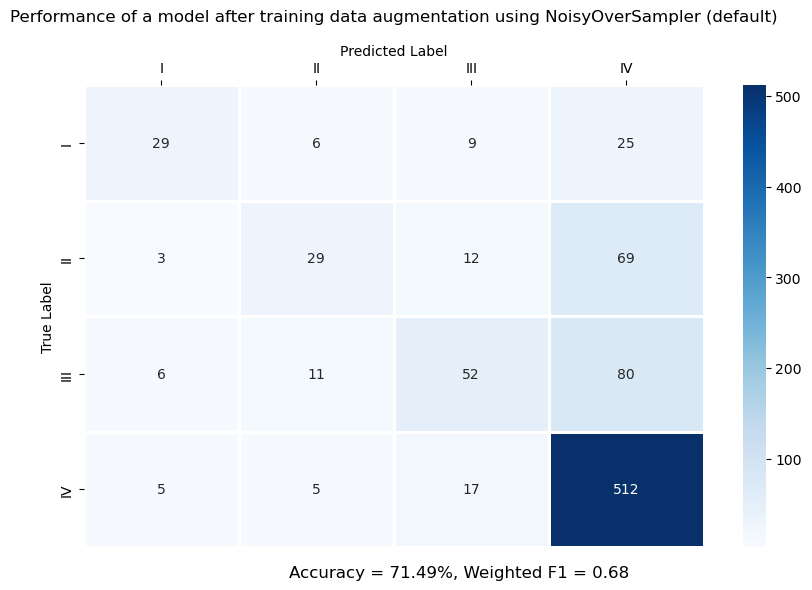

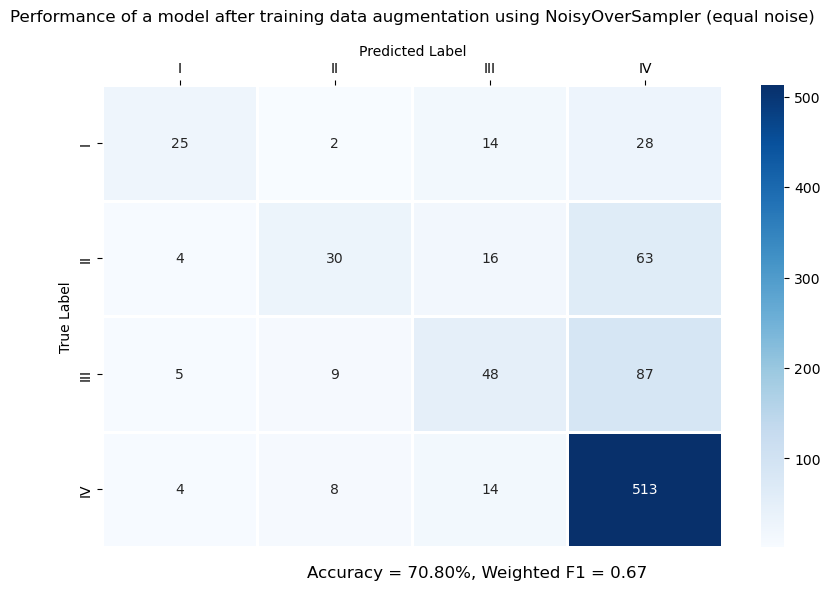

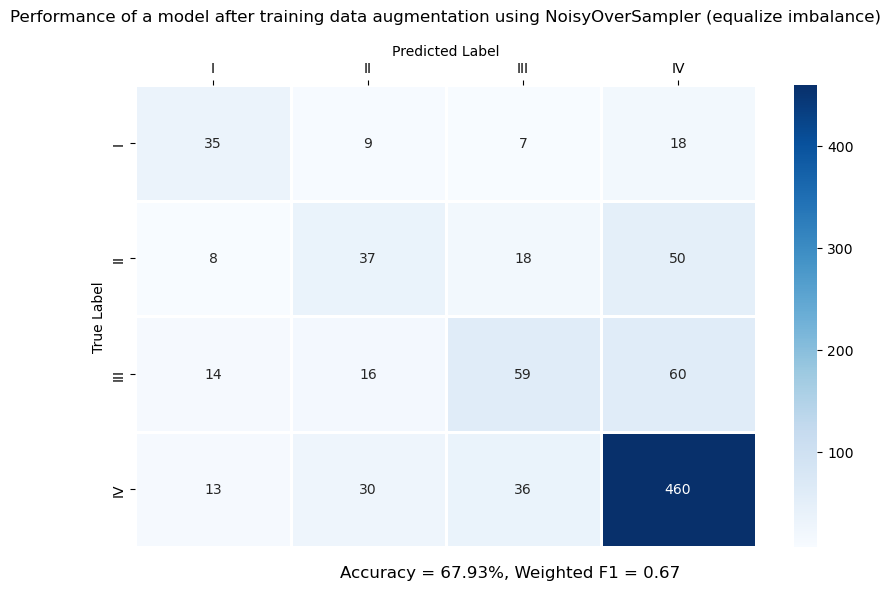

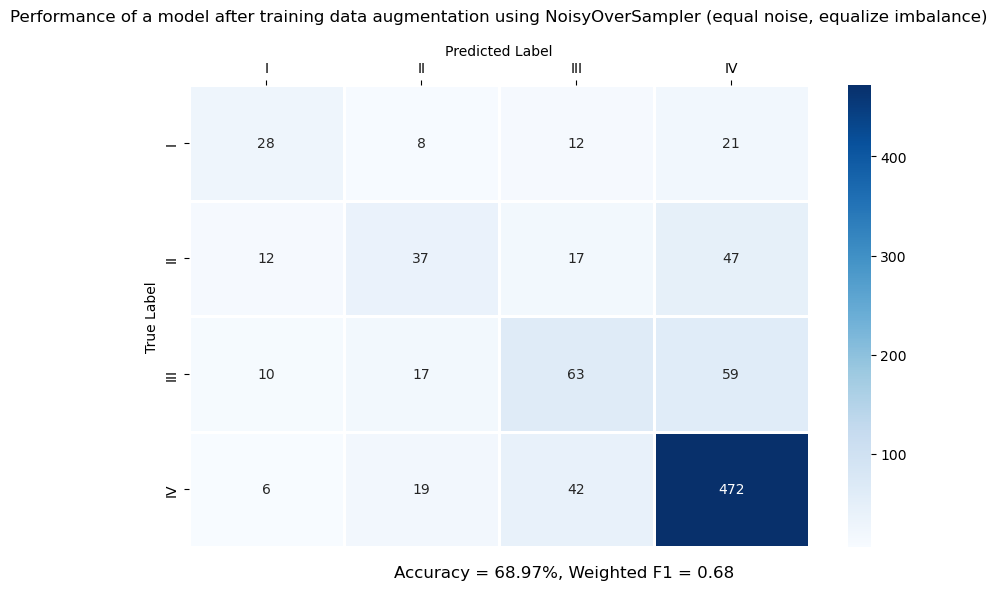

In [19]:
random_samplers_dict = {
    'default': NoisyOverSampler(3, 0.5, equal_noise_value=False, equalize_imbalance=False),
    'equal_noise': NoisyOverSampler(3, 0.5, equal_noise_value=True, equalize_imbalance=False),
    'equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=False, equalize_imbalance=True),
    'equal_noise_and_equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=True, equalize_imbalance=True),
}

for settings, random_sampler in random_samplers_dict.items():
    objective_func = partial(
        objective,
        X_train=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=random_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_multiclass,
        stratification_groups=stratification_groups_multiclass,
        label_col='Stage',
        over_sampler=random_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_multiclass['Stage'].values)
    labels = list(labels_encoding_multiclass.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = random_sampler.__class__.__name__
    settings_str = ', '.join([setting.replace('_', ' ') for setting in settings.split('_and_')])
    title = f'Performance of a model after training data augmentation using {over_sampler_name} ({settings_str})'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}_{settings}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Binary classification

In [20]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

Check models performance after data augmentation using random noise with different settings

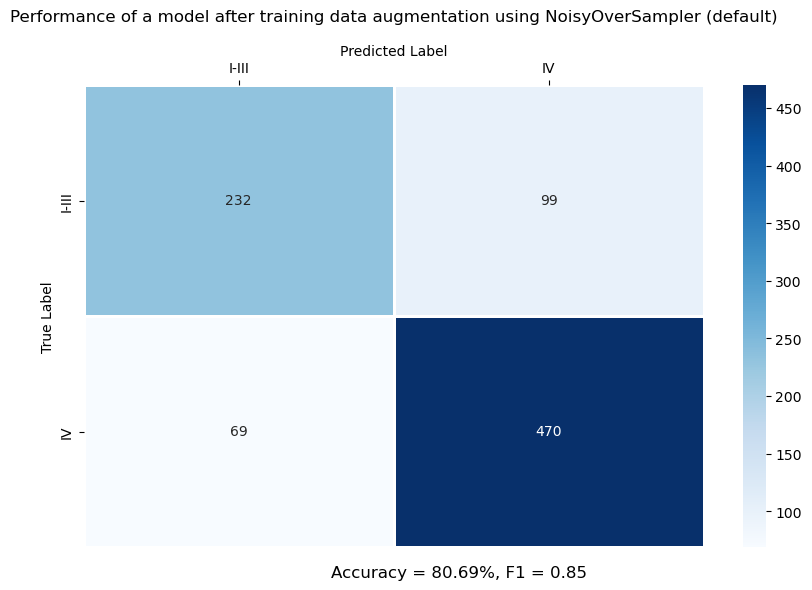

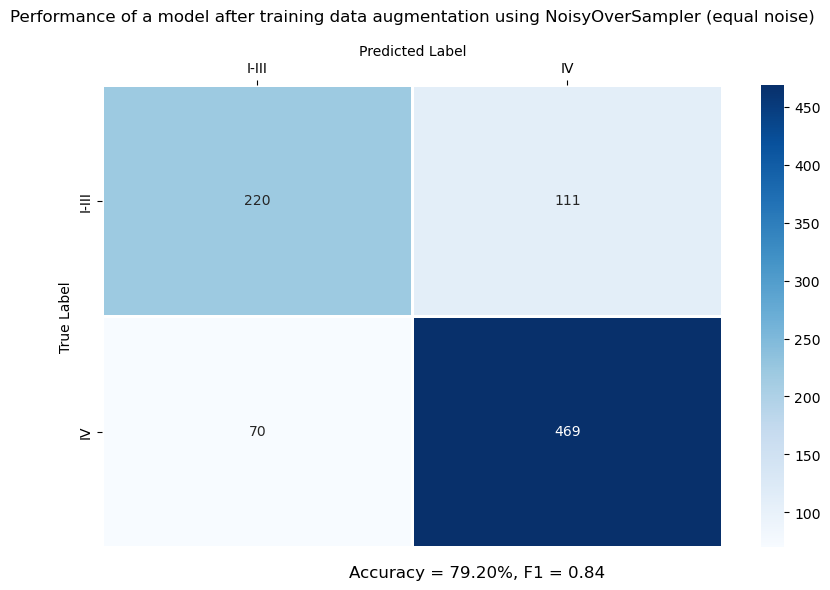

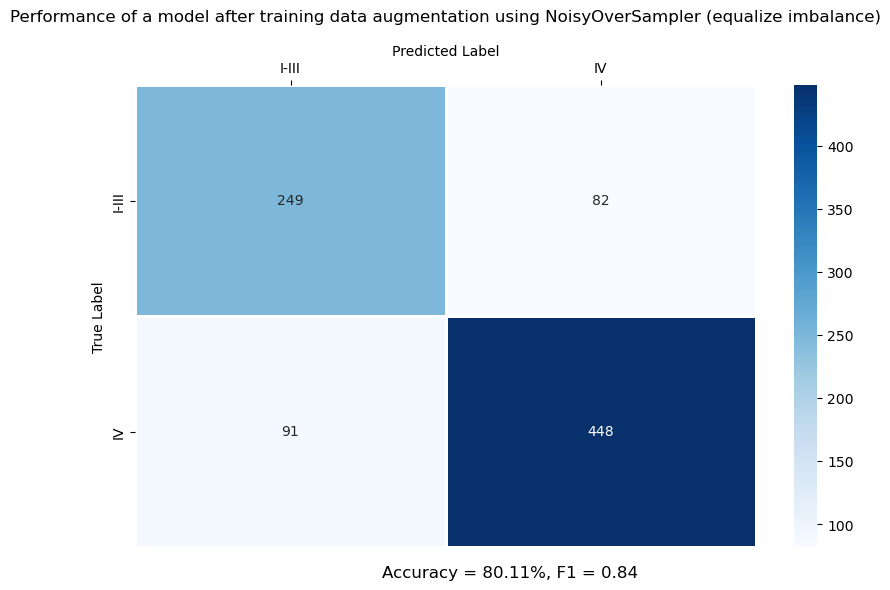

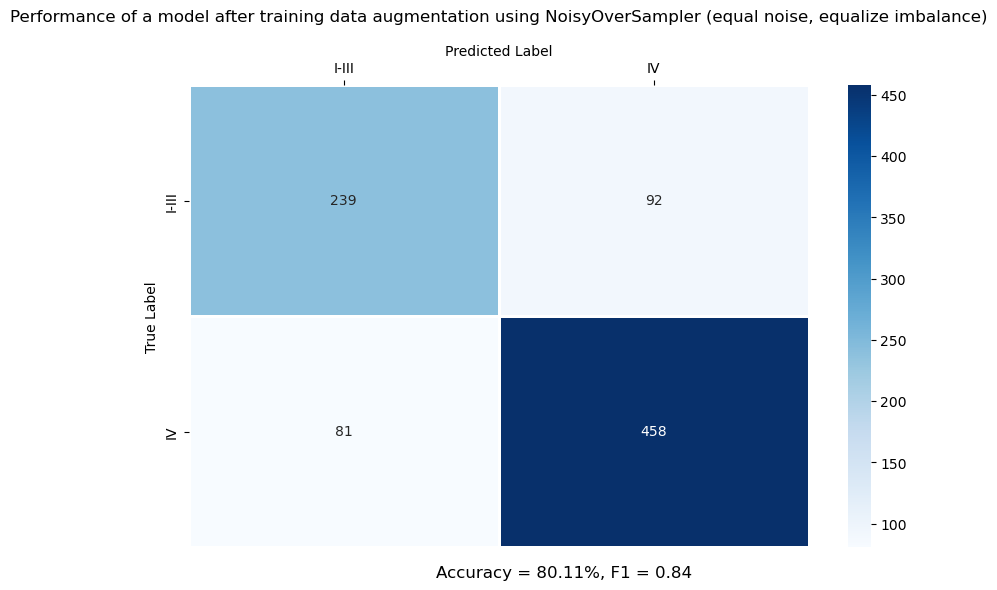

In [21]:
random_samplers_dict = {
    'default': NoisyOverSampler(3, 0.5, equal_noise_value=False, equalize_imbalance=False),
    'equal_noise': NoisyOverSampler(3, 0.5, equal_noise_value=True, equalize_imbalance=False),
    'equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=False, equalize_imbalance=True),
    'equal_noise_and_equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=True, equalize_imbalance=True),
}

for settings, random_sampler in random_samplers_dict.items():
    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=random_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary,
        stratification_groups=stratification_groups_binary,
        label_col='Stage',
        over_sampler=random_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_binary['Stage'].values)
    labels = list(labels_encoding_binary.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = random_sampler.__class__.__name__
    settings_str = ', '.join([setting.replace('_', ' ') for setting in settings.split('_and_')])
    title = f'Performance of a model after training data augmentation using {over_sampler_name} ({settings_str})'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}_{settings}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Binary classification (stages: I-II vs III-IV)

In [22]:
xgb_config = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
}

scoring_func = balanced_accuracy_score

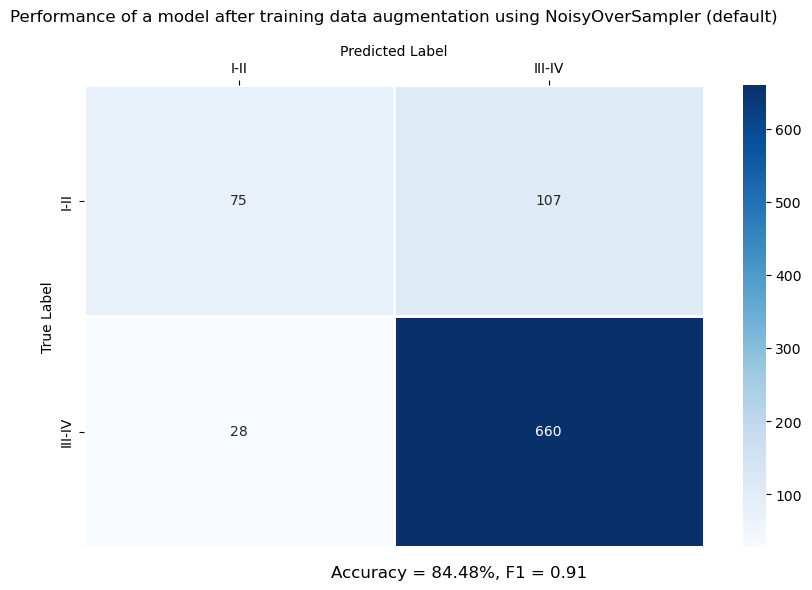

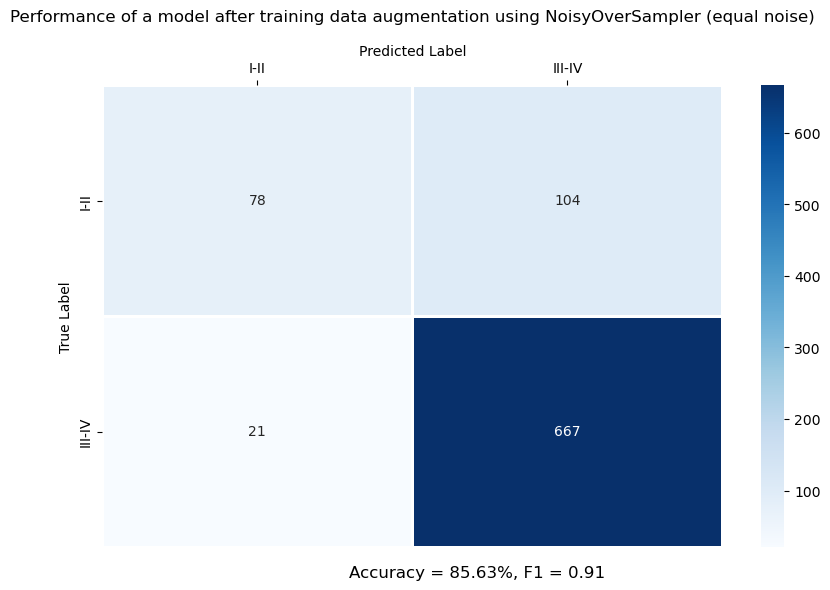

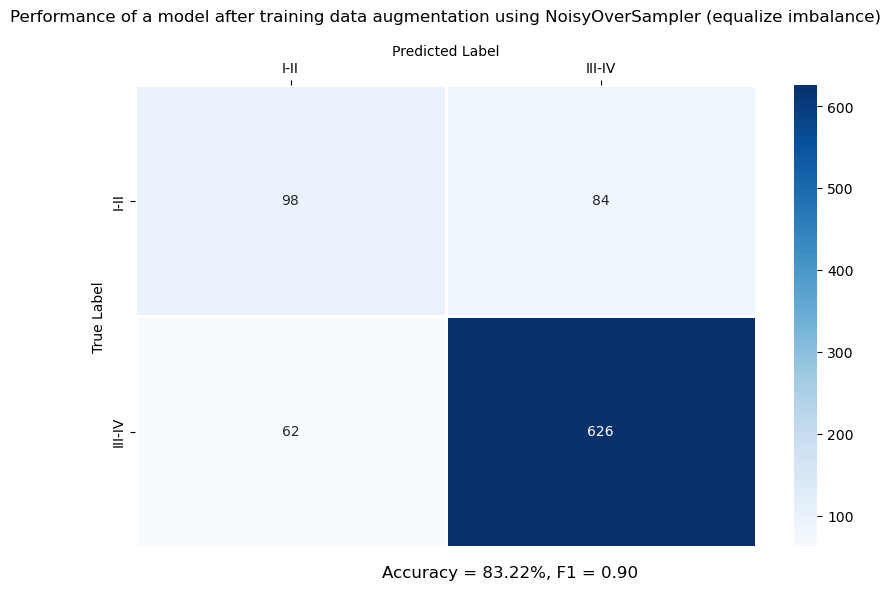

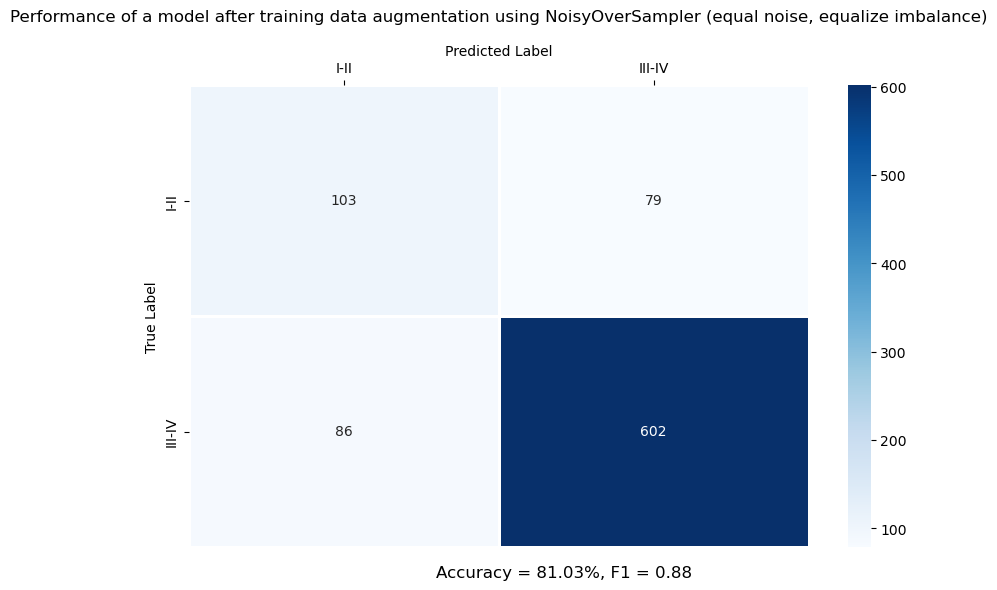

In [23]:
random_samplers_dict = {
    'default': NoisyOverSampler(3, 0.5, equal_noise_value=False, equalize_imbalance=False),
    'equal_noise': NoisyOverSampler(3, 0.5, equal_noise_value=True, equalize_imbalance=False),
    'equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=False, equalize_imbalance=True),
    'equal_noise_and_equalize_imbalance': NoisyOverSampler(2, 0.5, equal_noise_value=True, equalize_imbalance=True),
}

for settings, random_sampler in random_samplers_dict.items():
    objective_func = partial(
        objective,
        X_train=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        xgb_config=xgb_config,
        scoring=scoring_func,
        over_sampler=random_sampler
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reduced_binary_2,
        stratification_groups=stratification_groups_binary_2,
        label_col='Stage',
        over_sampler=random_sampler,
        n_splits=10
    )
    y_true = list(X_train_reduced_binary_2['Stage'].values)
    labels = list(labels_encoding_binary_2.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int))
    cm = confusion_matrix(y_true, y_pred.astype(int))
    
    over_sampler_name = random_sampler.__class__.__name__
    settings_str = ', '.join([setting.replace('_', ' ') for setting in settings.split('_and_')])
    title = f'Performance of a model after training data augmentation using {over_sampler_name} ({settings_str})'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
    
    filename = f'{over_sampler_name}_{settings}.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))